# Problem 1 - Answers

There are generally many routes to simulating a physics problem in Python. Some of these will be more efficient, particularly those that rely on functions in libraries like numpy and scipy that are built on well optimised, compiled code. This problem builds functionality that will be used in Problems 2 and 3 for doing thermodynamics simulation. But we will try doing the same thing in three different ways, and will see that we can get 10-100 times speed-up by doing it the 'right' way. 

## The Problem

Many thermodynamic principles can be tested numerically by simulating a large number of interacting particles. If you have done the Thermodynamics problem in 2nd Year Computing, you will have seen how simulating the collisions of hard spheres can reproduce certain important phenomena. However, the approach to modelling used there does not allow implementation of interparticle forces, which are important in real fluids. 

In the following sections, your task will be to implement a simulation of $n$ identical particles, interacting via a simple Coulomb-like force:

$$ \mathbf{F} = \frac{\alpha}{r^3}\mathbf{r} $$

A simple simulation suitable for testing will use $\alpha=1$, will sample initial particle positions randomly in the unit square, and will give particles zero initial speed. A simulation time step of 0.001 will be suitable. 

Write a function `initialise` which takes the number of particles $n$ as an argument. This function should return an $n\times 2$ numpy array of random 2D initial particle positions, and an $n\times 2$ array of zeros, for the initial particle velocities. 

In each of the following sections, define a function that takes the number of particles $n$, and $n\times 2$ position and velocity arrays as arguments. These functions used the method specified to step the position and velocity arrays one step forward in time. 


In [1]:
# Useful imports

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.distance import pdist,squareform
from IPython.display import HTML
import time

dt = 0.001

def initialise(n):
    pos = np.random.uniform(size=(n,2))
    vel = np.zeros(shape=(n,2))
    return pos,vel

## Nested for loops

Use a nested pair of for loops, each iterating over all $n$ particles. For a given pair of different particles i and j, calculate the force of j acting on i. Sum over all the forces acting on particle i, and use this total force to do an Euler step and update the positions and velocities. 

In [2]:
def method1(n,pos,vel):
    for i in range(n):
        Ftotal = np.array([0.0,0.0])   # vector for total force
        for j in range(n):
            if i != j:
                # calculate distance between i and j
                dist = np.linalg.norm(pos[j]-pos[i])  
                
                # find the unit vector pointing from i to j
                vec = (pos[j]-pos[i]) / dist 
                
                # calculate the force vector of j acting on i and sum
                Ftotal += -1 / dist**2 * vec
                
    # Euler step
    vel[i] += Ftotal * dt
    pos[i] += vel[i] * dt

    return pos,vel

## SciPy pdist function

Look up the documentation for the <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html">scipy.spatial.distance.pdist</a> function. This is a useful function which calculates the matrix of distances between each pair of points in an N-dimensional space. 

```{note}
You will see that the return of pdist is a 'condensed' matrix. To convert to a conventional square matrix, use scipy.spatial.distance.squareform.
```

pdist will allow us to implement this functionality without using any for loops. However, we have a problem to work around: pdist returns pairwise scalar distances, but to find the forces we require pairwise *displacements*. pdist will take as an argument a function defining a custom metric, however this must still be a scalar. Try to figure out you can use multiple calls to pdist to work around this issue. 

We can split our position array into separate X and Y arrays, and use pdist on those separately to get around the distance vs displacement issue. One problem with this is that we still lose the signs associated with the displacements. While we could solve this with only 2 calls to pdist, it would be a bit ugly and so I offer the below solution which uses 4 calls to pdist, two of which use the function sgn to define a custom metric for pdist which just gets back the sign information.

This sign matrix comes back from pdist as a symmetric matrix, but of course it should be antisymmetric (the sign of the displacement from particle i to particle j is opposite the displacement from j to i). So we flip the signs of elements of the matrix below the diagonal. 

Note that accessing `[norms!=0]` of an array is to avoid division by zero issues.

In [3]:
def sgn(u,v):
    if np.all(u>v):
        return 1
    else:
        return -1

def method2(n,pos,vel):
    # split pos into separate X and Y arrays
    X = np.reshape(pos[:,0],(-1,1))
    Y = np.reshape(pos[:,1],(-1,1))
    
    # get pairwise distances along X and Y axes separately
    dX = squareform(pdist(X))
    dY = squareform(pdist(Y))
    
    # calculate 2D distances between each pair
    norms = np.sqrt(dX**2+dY**2)
    
    # use the custom metric to get the signs of the displacements in each axis
    SX = squareform(pdist(X,sgn))
    SY = squareform(pdist(Y,sgn))
    
    # correct the signs (see description above)
    SX = np.triu(SX) - np.tril(SX)
    SY = np.triu(SY) - np.tril(SY)

    # normalise and sign
    dX[norms!=0] *= SX[norms!=0] / norms[norms!=0]
    dY[norms!=0] *= SY[norms!=0] / norms[norms!=0]

    # calculate magnitude of force
    C = np.zeros((n,n))
    C[norms!=0] = -1 / norms[norms!=0]**2

    dX *= C
    dY *= C

    # Euler step
    vel[:,0] += np.sum(dX,axis=0)*dt
    vel[:,1] += np.sum(dY,axis=0)*dt
    pos += vel * dt
    
    return pos,vel

## Array flattening

A third way of approaching this problem is to use only a single for loop rather than two nested loops. This can be done using the functionality of numpy arrays.

This will require taking the difference between appropriate slices of the position array. To assign these displacements into a square matrix, use of the numpy 'flat' property of an array will be required. You can deal with each dimension separately.

The solution is to loop over the n-1 diagonal slices of one half of the square matrix of displacements. You can access the ith diagonal slice in the upper triangle (where i=0 is the main diagonal) with `.flat[i:n*(n-i):n+1]`. You can access the X displacements corresponding to each element of this diagonal slice with `(pos[:n-i,0] - pos[i:,0]).flat`.

To explain with an example: the i=1 diagonal of the matrix corresponds with the displacements between particles j and j+1. So you are filling this with the difference between slices of the position matrix that are offset by one row.

In [4]:
def method3(n,pos,vel):
    
    dX = np.zeros((n,n))
    dY = np.zeros((n,n))

    for i in range(1,n):
        dX.flat[i:n*(n-i):n+1] = (pos[:n-i,0] - pos[i:,0]).flat
        dY.flat[i:n*(n-i):n+1] = (pos[:n-i,1] - pos[i:,1]).flat

    # calculate distances and get the matrix of force magnitudes
    norms = np.sqrt(dX**2 + dY**2)
    C = np.zeros((n,n))
    C[norms!=0] = -1 / norms[norms!=0]**3

    # multiply displacements by force magnitudes to get force vectors
    dX *= C
    dY *= C
    
    # make the matrices antisymmetric
    dX += -1 * np.rot90(np.fliplr(dX))
    dY += -1 * np.rot90(np.fliplr(dY))

    # Euler step
    vel[:,0] += np.sum(dX,axis=0)*dt
    vel[:,1] += np.sum(dY,axis=0)*dt
    pos += vel * dt
    
    return pos,vel

## Testing

a) Generate initial position and velocity arrays for 5 particles. Test these on the three different methods you've implemented, and check that you get the same results for the iterated velocity for all 3 methods.

In [5]:
pos,vel = initialise(5)
p1,v1 = method1(5,pos,vel)
p2,v2 = method2(5,pos,vel)
p3,v3 = method3(5,pos,vel)
print(v1)
print(v2)
print(v3)

[[ 0.03016846 -0.00427355]
 [-0.01116495  0.13068978]
 [-0.02039495 -0.0081794 ]
 [-0.00148045 -0.1052142 ]
 [ 0.00430788 -0.01953416]]
[[ 0.03016846 -0.00427355]
 [-0.01116495  0.13068978]
 [-0.02039495 -0.0081794 ]
 [-0.00148045 -0.1052142 ]
 [ 0.00430788 -0.01953416]]
[[ 0.03016846 -0.00427355]
 [-0.01116495  0.13068978]
 [-0.02039495 -0.0081794 ]
 [-0.00148045 -0.1052142 ]
 [ 0.00430788 -0.01953416]]


Clearly, all three methods are yielding the same results to the precision displayed.

b) Create a list of values for $n$, ranging from around 10 to around 1000. Write a loop over these values, and for each use the time.time() function to measure the time each of the three methods takes to run one time step using this number of particles. Make a plot comparing these three methods. 

In [6]:
ns = [5,10,20,40,80,160,320,640,1280]
times1 = []
times2 = []
times3 = []
for n in ns:
    pos,vel = initialise(n)
    t = time.time()
    
    # Method 1: Nested for loops
    p1,v1 = method1(n,pos,vel)
    times1.append(time.time()-t)
    t = time.time()
    
    # Method 2: SciPy pdist
    p2,v2 = method2(n,pos,vel)
    times2.append(time.time()-t)
    t = time.time()
    
    # Method 3: Array flattening
    p3,v3 = method3(n,pos,vel)
    times3.append(time.time()-t)

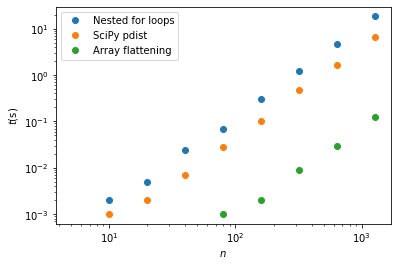

In [7]:
plt.plot(ns,times1,'o',label='Nested for loops')
plt.plot(ns,times2,'o',label='SciPy pdist')
plt.plot(ns,times3,'o',label='Array flattening')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$n$')
plt.ylabel(r'$t$(s)')
plt.legend()

## Conclusions

If I can convince you of one thing from this exercise, it's that if efficiency is important:

**Nested for loops should generally be avoided**

They are terribly inefficient in Python, and there are generally other ways of doing it (even if they are less obvious).

I was surprised that using pdist was not significantly faster that using for loops (generally purpose-built numpy/scipy functions are much more efficient). It was clearly hindered by our needing 4 calls to pdist for the work around to get displacements. 

The approach involving array flattening was the clear winner here - it is around 100 times faster than using nested for loops, for large n. It is able to take advantage of the efficiency of numpy operations (which employ compiled code), without the overhead involved in using pdist. 